In [2]:
!pip install pytorch-lightning==1.6.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from skimage.io import imread
import torch
import pandas as pd
from glob import glob
import os
import torchvision

In [7]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = imread(self.images[idx])
        return torch.from_numpy(img).unsqueeze(0), self.labels[idx]
        #return torch.from_numpy(img).unsqueeze(1), self.labels[idx]


class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, path, batch_size):
        super().__init__()
        self.path = path
        self.batch_size = batch_size

    
    def generate_df(self, l1, l2):
        return pd.DataFrame({
            'image': l1 + l2,
            'label': [1] * len(l1) + [0] * len(l2)
        })

    
    def setup(self, stage = None):
        train_3 = glob(os.path.join(self.path, 'train', '3', '*.png'))
        train_no3 = glob(os.path.join(self.path, 'train', 'no3', '*.png'))
        self.train_df = self.generate_df(train_3, train_no3)
        test_3 = glob(os.path.join(self.path, 'test', '3', '*.png'))
        test_no3 = glob(os.path.join(self.path, 'test', 'no3', '*.png'))
        self.test_df = self.generate_df(test_3, test_no3)
        self.train_ds = MNISTDataset(self.train_df.image.values, self.train_df.label.values)
        self.test_ds = MNISTDataset(self.test_df.image.values, self.test_df.label.values)

    
    def train_dataloader(self):
        return DataLoader(self.train_ds, shuffle=True, batch_size=self.batch_size)

    
    def val_dataloader(self, batch_size=None, shuffle=False):
        return DataLoader(
            self.test_ds, 
            batch_size=self.batch_size if batch_size is None else batch_size,
            shuffle=shuffle
        )

In [22]:
from pathlib import Path

path = Path('dataset')

dm = MNISTDataModule(path, batch_size=25)
dm.setup()

imgs, labels = next(iter(dm.train_dataloader()))

imgs.shape, imgs.dtype, imgs.max(), imgs.min(), labels.shape

(torch.Size([25, 1, 28, 28]),
 torch.uint8,
 tensor(255, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 torch.Size([25]))

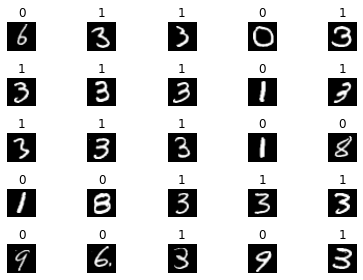

In [9]:
import matplotlib.pyplot as plt

rows, cols = 5, 5
fig, axs = plt.subplots(rows, cols)
imgs, labels = next(iter(dm.train_dataloader()))
for row in range(rows):
    for col in range(cols):
        axs[row, col].imshow(imgs[row * cols + col].squeeze(0), cmap='gray')
        axs[row, col].set_title(labels[row * cols + col].item())
        axs[row, col].axis('off')
plt.tight_layout()
plt.show()

In [23]:
import torch.nn as nn
import torch.nn.functional as F
import torch

def block_conv(input_channels, output_channels, kernel_size=3, padding=1, stride=1, pool_kernel=2, pool_stride=2):
    return nn.Sequential(
        nn.Conv2d(input_channels, output_channels, kernel_size, padding=padding, stride=stride),
        nn.ReLU(),
        nn.MaxPool2d(pool_kernel, stride=pool_stride)
    )

class MNISTModule(pl.LightningModule):
    def __init__(self, n_channels=1, n_outputs=1):
        super().__init__()
        self.conv1 = block_conv(n_channels, 32)
        #self.conv2 = block_conv(32, 64)
        self.mlp = nn.Sequential(
            nn.Linear(14 * 14 * 32, 100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )
    

    def forward(self, x):
        x = x.float() / 255
        x = self.conv1(x)
        #x = self.conv2(x)
        x = x.view(x.shape[0], -1)
        x = self.mlp(x).squeeze(-1)
        return x


    def predict(self, x):
        self.eval()
        with torch.no_grad():
            return torch.sigmoid(self(x))

    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float())
        preds = torch.sigmoid(y_hat) > 0.5
        acc = (preds.long() == y).float().mean()
        #self.log('loss', loss)
        self.log('acc', acc,  prog_bar=True)
        return loss

    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.binary_cross_entropy_with_logits(y_hat, y.float())
        preds = torch.sigmoid(y_hat) > 0.5
        val_acc = (preds.long() == y).float().mean()
        self.log('val_loss', val_loss,  prog_bar=True)
        self.log('val_acc', val_acc,  prog_bar=True)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())






In [80]:
module = MNISTModule()
module

MNISTModule(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [86]:
output = module(torch.randn(25, 28, 28))
output.shape

torch.Size([25])

In [24]:
dm = MNISTDataModule(path, batch_size=25)
module = MNISTModule()
trainer = pl.Trainer(
    max_epochs = 10,
    logger=None,
    enable_checkpointing=False

)
trainer.fit(module, dm)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1815: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,

  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Sequential | 320   
1 | mlp   | Sequential | 627 K 
-------------------------------------
627 K     Trainable params
0         Non-trainable params
627 K     Total params
2.511     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

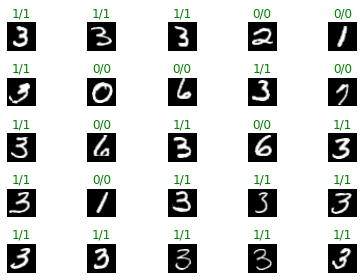

In [26]:
r, c = 5, 5 
fig, axs = plt.subplots(r, c)
imgs, labels = next(iter(dm.val_dataloader(25, True)))
preds = module.predict(imgs) > 0.5
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(imgs[i * c + j].squeeze(0), cmap='gray')
        label = labels[i * c + j].item()
        pred = preds[i * c + j].long().item()
        axs[i, j].set_title(f'{label}/{pred}', color = 'green' if label == pred else 'red')
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()